In [ ]:
! mv /content/kaggle.json /root/.kaggle

In [ ]:
! kaggle datasets download -d aytekinabisoy/image-captioning2040-images

 95% 62.0M/65.4M [00:02<00:00, 35.9MB/s]
100% 65.4M/65.4M [00:02<00:00, 27.2MB/s]


In [ ]:
! unzip /content/image-captioning2040-images.zip

In [ ]:
import pandas as pd
import os
import cv2 as cv
import numpy as np

In [ ]:
df = pd.read_csv("/content/file.csv")

In [ ]:
x = []
y = []

In [ ]:
dir_path = "/content/dataset/content/images"

In [ ]:
for i in os.listdir(dir_path) :
  img = cv.imread(os.path.join(dir_path,i))
  img.resize((224,224,3))
  x.append(img)

In [ ]:
for i in df.caption :
  y.append(i.lower())

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
words = []

In [ ]:
for i in y :
  for j in i.split() :
    if j not in words :
      words.append(j)

In [ ]:
len(words)

4350

In [ ]:
l = 0
for i in y :
  l = max(l, len(i))
print(l)

758


In [ ]:
words_map = {}
i = 1
for j in words :
  words_map[i] = j
  i = i+1

In [ ]:
state_h = []
state_c = []

In [ ]:
decoder_input = np.zeros(shape=(2040,760,4351))
decoder_output = np.zeros(shape=(2040,760,4351))

In [ ]:
image_input = tf.keras.layers.Input(shape=(224,224,3), name="Image_Input")

image_cnn = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280],
                   trainable=False, name="MobileNet_Feature_Vector")

encoded_image = image_cnn(image_input)

In [ ]:
states = [encoded_image, encoded_image]

In [ ]:
decoder_input = tf.keras.layers.Input(shape = (None,4351), name="Decoder_Input")

decoder_lstm = tf.keras.layers.LSTM(1280, return_sequences=True, return_state=True, name="Decoder_LSTM")

decoder_seq, decoder_h, decoder_s = decoder_lstm(decoder_input,initial_state=[encoded_image, encoded_image])

decoder_dense = tf.keras.layers.Dense(4351, activation='softmax', name="Dcoder_Dense")

decoder_output = decoder_dense(decoder_seq)

In [ ]:
trasformer = tf.keras.Model(inputs=[image_input, decoder_input], outputs=decoder_output)

In [ ]:
trasformer.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
trasformer.fit(x=[x,decoder_input], y=decoder_output, epochs=2000, batch_size=20)

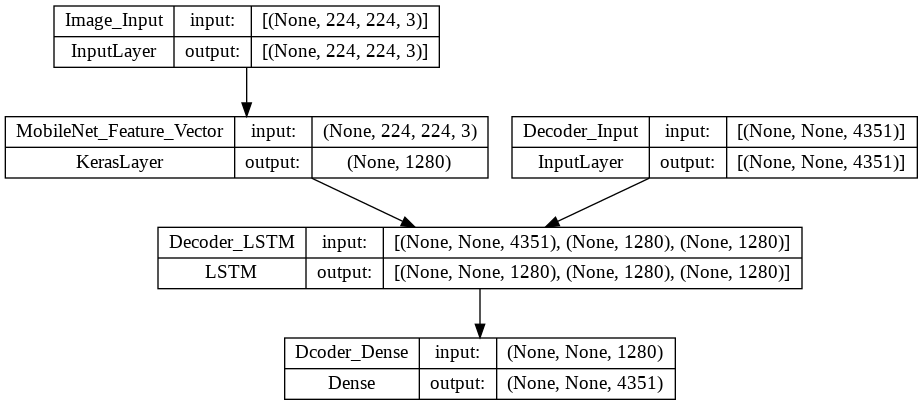

In [ ]:
tf.keras.utils.plot_model(trasformer, show_shapes=True)

In [ ]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoded_image)

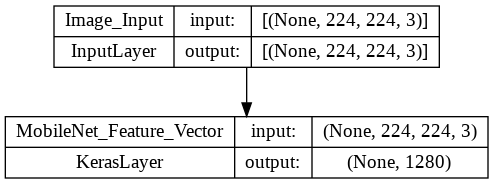

In [ ]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

In [ ]:
decoder = tf.keras.Model(inputs=[decoder_input, encoded_image, encoded_image], outputs=decoder_output)

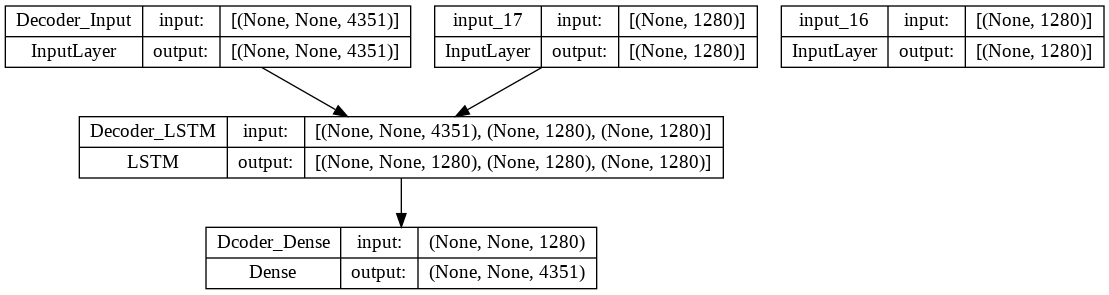

In [ ]:
tf.keras.utils.plot_model(decoder, show_shapes=True)